In [271]:
import numpy as np
import pandas as pd
import os

#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.5.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [272]:
N = 8

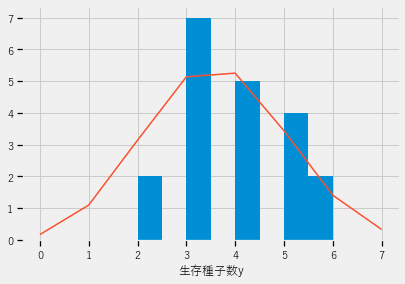

q_hat: 0.48125


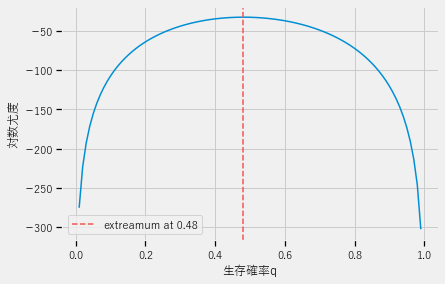

In [273]:
dist = tfd.Binomial(total_count=N, probs=0.45)
n_sample = 20
data = dist.sample(20).numpy()

xx = np.arange(0, N)

plt.hist(data, bins=N)
plt.plot(xx, dist.prob(xx) * n_sample)
plt.xlabel("生存種子数y")
plt.show()

sum_survive = tf.reduce_sum(data)
q_hat = sum_survive / (N * n_sample)
print("q_hat:", q_hat.numpy())

lin_q = np.linspace(0.0, 1.0, 100)
log_likelihoods = []
for q in lin_q:
    dist = tfd.Binomial(total_count=N, probs=q)
    log_likelihood = tf.reduce_sum(dist.log_prob(data))
    log_likelihoods.append(log_likelihood)

plt.plot(lin_q, log_likelihoods)
plt.axvline(x=q_hat, color=TFColor[0], linestyle="--", label="extreamum at %.2f" %(q_hat))
plt.legend()
plt.xlabel("生存確率q")
plt.ylabel("対数尤度")
plt.show()

No handles with labels found to put in legend.


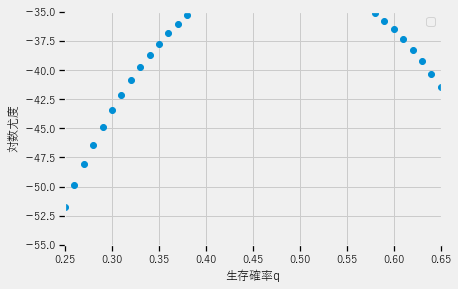

In [274]:
lin_q = np.linspace(0.01, 0.99, 99)
log_likelihoods = []
for q in lin_q:
    dist = tfd.Binomial(total_count=N, probs=q)
    log_likelihood = tf.reduce_sum(dist.log_prob(data))
    log_likelihoods.append(log_likelihood)

plt.scatter(lin_q, log_likelihoods)
plt.legend()
plt.xlim(0.25, 0.65)
plt.ylim(-55, -35)
plt.xlabel("生存確率q")
plt.ylabel("対数尤度")
plt.show()

# 8.2 ふらふら試行錯誤による最尤推定

ValueError: x and y must have same first dimension, but have shapes (500,) and (100,)

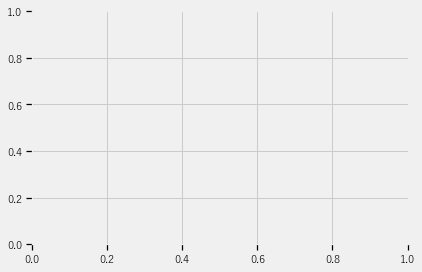

In [275]:
def furafura(q, L, initial_q=0.3, num_iter=100):
    idx_his = []
    idx = np.argmin(np.abs(q - initial_q))
    assert idx > 0 and idx < len(L) - 1

    for i in range(num_iter):
        if tfd.Bernoulli(probs=0.5).sample(1).numpy()[0] == 1:
            next_idx = idx - 1
        else:
            next_idx = idx + 1
        if next_idx >= len(L):
            next_idx = next_idx - 1
        
        log_likelihood = L[idx]
        next_loglikelihood = L[next_idx]
        if next_loglikelihood > log_likelihood:
            idx = next_idx
        idx_his.append(idx)

    return idx_his

idx_his_03 = furafura(lin_q, log_likelihoods, 0.3, 100)
idx_his_06 = furafura(lin_q, log_likelihoods, 0.6, 100)
xx = np.arange(0, len(idx_his))

plt.plot(xx, np.take(lin_q, idx_his_03), label="q=0.3から開始した試行錯誤")
plt.plot(xx, np.take(lin_q, idx_his_06), linestyle="--", label="q=0.6から開始した試行錯誤")
plt.xlabel("試行錯誤のステップ数")
plt.ylabel("生存確率q")
plt.legend()
plt.show()

# 8.3 メトロポリス

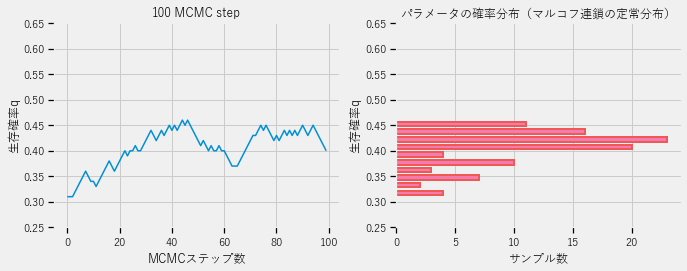

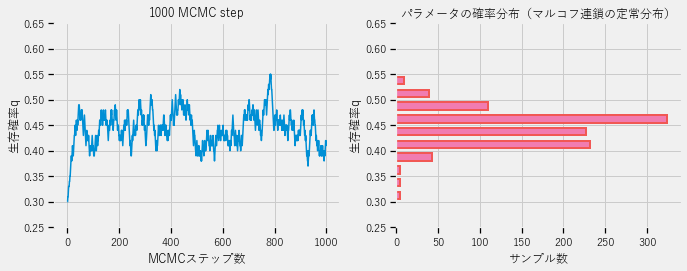

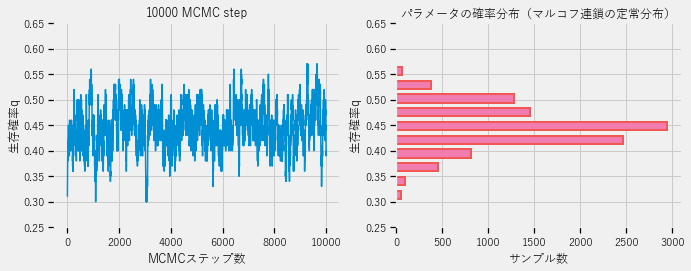

In [ ]:
def metropolis(q, L, initial_q=0.3, num_iter=100):
    idx_his = []
    idx = np.argmin(np.abs(q - initial_q))
    assert idx > 0 and idx < len(L) - 1

    for i in range(num_iter):
        if tfd.Bernoulli(probs=0.5).sample(1).numpy()[0] == 1:
            next_idx = idx - 1
        else:
            next_idx = idx + 1
        if next_idx >= len(L):
            next_idx = next_idx - 1
        
        log_likelihood = L[idx]
        next_loglikelihood = L[next_idx]
        if next_loglikelihood > log_likelihood:
            idx = next_idx
        else:
            r = tf.exp(next_loglikelihood - log_likelihood)
            if tfd.Bernoulli(probs=r).sample(1).numpy()[0] == 1:
                idx = next_idx
        idx_his.append(idx)

    return idx_his

def draw_plot(ax, q, his):
    data = tf.gather(q, his)
    xx = tf.range(0, len(data))
    ax.plot(xx, data)
    ax.set_xlabel("MCMCステップ数")
    ax.set_ylabel("生存確率q")
    ax.set_title("%i MCMC step" %len(data))
    ax.set_ylim(0.25, 0.65)

def draw_hist(ax, q, his):
    ax.hist(
        tf.gather(q, his).numpy(), 
        orientation="horizontal",
        rwidth=.6, color=TFColor[4], edgecolor=TFColor[0], linewidth=2.0
    )
    ax.set_xlabel("サンプル数")
    ax.set_ylabel("生存確率q")
    ax.set_title("パラメータの確率分布（マルコフ連鎖の定常分布）")
    ax.set_ylim(0.25, 0.65)

idx_his = metropolis(lin_q, log_likelihoods, 0.3, 100)
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
draw_plot(axes[0], lin_q, idx_his)
draw_hist(axes[1], lin_q, idx_his)
plt.show()

idx_his = metropolis(lin_q, log_likelihoods, 0.3, 1000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
draw_plot(axes[0], lin_q, idx_his)
draw_hist(axes[1], lin_q, idx_his)
plt.show()

idx_his = metropolis(lin_q, log_likelihoods, 0.3, 10000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
draw_plot(axes[0], lin_q, idx_his)
draw_hist(axes[1], lin_q, idx_his)
plt.show()

## マルコフ連鎖の定常分布

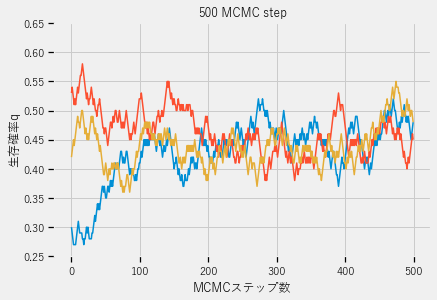

In [270]:
def draw_plot(ax, q, his):
    data = tf.gather(q, his)
    xx = tf.range(0, len(data))
    ax.plot(xx, data)
    ax.xlabel("MCMCステップ数")
    ax.ylabel("生存確率q")
    ax.title("%i MCMC step" %len(data))
    ax.ylim(0.25, 0.65)

idx_his = metropolis(lin_q, log_likelihoods, np.random.uniform(0.25, 0.65), 500)
draw_plot(plt, lin_q, idx_his)

idx_his = metropolis(lin_q, log_likelihoods, np.random.uniform(0.25, 0.65), 500)
draw_plot(plt, lin_q, idx_his)

idx_his = metropolis(lin_q, log_likelihoods, np.random.uniform(0.25, 0.65), 500)
draw_plot(plt, lin_q, idx_his)

plt.show()